In [1]:
import sys
sys.path.append('/storage/vbutoi/projects')
sys.path.append('/storage/vbutoi/libraries')
sys.path.append('/storage/vbutoi/projects/ESE')
sys.path.append('/storage/vbutoi/projects/UniverSeg')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style("darkgrid")
sns.set_context("talk")

import os 
os.environ['DATAPATH'] = ':'.join((
       '/storage/vbutoi/datasets',
))

from ese.experiment.analysis.analyze_inf import load_cal_inference_stats
# Results loader object does everything
from ionpy.analysis import ResultsLoader
from pathlib import Path
root = Path("/storage/vbutoi/scratch/ESE")
rs = ResultsLoader()

# For using code without restarting.
%load_ext autoreload
%autoreload 2
# For using yaml configs.
%load_ext yamlmagic

/storage/vbutoi/projects/ionpy/pandas/register.py:47: UserWarning: registration of accessor <class 'ionpy.pandas.register.register_series_method.<locals>.inner.<locals>.AccessorMethod'> under name 'fillNA' for type <class 'pandas.core.series.Series'> is overriding a preexisting attribute with the same name.
  register_series_accessor(method.__name__)(AccessorMethod)
/storage/vbutoi/projects/ionpy/pandas/register.py:47: UserWarning: registration of accessor <class 'ionpy.pandas.register.register_series_method.<locals>.inner.<locals>.AccessorMethod'> under name 'isNA' for type <class 'pandas.core.series.Series'> is overriding a preexisting attribute with the same name.
  register_series_accessor(method.__name__)(AccessorMethod)
/storage/vbutoi/projects/ionpy/pandas/register.py:47: UserWarning: registration of accessor <class 'ionpy.pandas.register.register_series_method.<locals>.inner.<locals>.AccessorMethod'> under name 'notNA' for type <class 'pandas.core.series.Series'> is overriding 

In [2]:
%%yaml results_cfg 

log:
    root: /storage/vbutoi/scratch/ESE/inference
    inference_groups: 
        - '06_17_24_EXPANDED_DRIVE_to_STARE_Hard'
        - '06_17_24_EXPANDED_DRIVE_to_STARE_SVLS'

options:
    add_dice_loss_rows: True
    drop_nan_metric_rows: True 
    remove_shared_columns: False
    equal_rows_per_cfg_assert: False 

<IPython.core.display.Javascript object>

In [3]:
inference_df = load_cal_inference_stats(
    results_cfg=results_cfg,
    load_cached=False,
)

Error loading submitit directory: /storage/vbutoi/scratch/ESE/inference/06_17_24_EXPANDED_DRIVE_to_STARE_Hard/06_17_24_EXPANDED_DRIVE_to_STARE_Hard/submitit


/storage/vbutoi/projects/ESE/ese/experiment/analysis/analyze_inf.py:161: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  inference_df = pd.concat([inference_df, log_image_df])


Dropping (datapoint, metric) pairs with NaN metric score. Dropped from 4092 -> 4092 rows.
/storage/vbutoi/scratch/ESE/inference/06_17_24_EXPANDED_DRIVE_to_STARE_Hard/06_17_24_EXPANDED_DRIVE_to_STARE_Hard  20240617_204759-HXD2-4e0b72cbe3620e4dad01d0f2a78eb3bc    121
                                                                                                                   20240617_204911-WV8W-4e0b72cbe3620e4dad01d0f2a78eb3bc     11
/storage/vbutoi/scratch/ESE/inference/06_17_24_EXPANDED_DRIVE_to_STARE_Hard/STARE_Individual_Uncalibrated          20240617_205028-CYX0-c958c4bd031dd8e5a214e218265342f6    198
                                                                                                                   20240617_205032-DZEK-00a3df42d6f13c90c40fc54bc4d9f5ad    198
                                                                                                                   20240617_205036-TU9F-d58c31bdb823193e89496a01181b9363    198
                              

In [4]:
# For the purpose of this experiment, we only care about a few columns in particular:
exp_columns = [
    "data_id",
    "gt_volume",
    "hard_volume",
    "soft_volume",
    "pretrained_seed", 
    "pretrained_exp_root",
    "split",
]
# Take these columns of the inference_df, drop other columns.
volume_df = inference_df[exp_columns]
# Remove the duplicate rows.
volume_df = volume_df.drop_duplicates()

In [5]:
# Make two new columns, one for the soft volume error and one for the hard volume error.
volume_df['soft_volume_error'] = volume_df['soft_volume'] - volume_df['gt_volume']
volume_df['hard_volume_error'] = volume_df['hard_volume'] - volume_df['gt_volume']

# Make the normalized metric that divides the error by the ground truth volume.
volume_df['soft_norm_volume_error'] = volume_df['soft_volume_error'] / volume_df['gt_volume']
volume_df['hard_norm_volume_error'] = volume_df['hard_volume_error'] / volume_df['gt_volume']

# Library Funcs

In [6]:
def prepare_error_df(raw_df, groupby_keys):
    # Make a clone of the volume df.
    input_df = raw_df.copy()
    # Melt the dataframe to have a single column for the error.
    error_df = pd.melt(
        input_df,
        id_vars=groupby_keys,
        value_vars=["soft_volume_error", "hard_volume_error"],
        var_name="volume_type",
        value_name="error",
    )
    # Make some columns that are useful for plotting.
    error_df['abs_error'] = error_df['error'].abs()
    error_df['log_abs_error'] = error_df['error'].abs().apply(lambda x: np.log(x + 1))
    # Return the melted dataframe.
    return error_df


def calibrator(pretrained_exp_root):
    if "SVLS" in pretrained_exp_root:
        return "SVLS"
    else:
        return "Uncalibrated"


def process_volume_types(input_df):
    # Make a clone of the input_df
    df = input_df.copy()
    # Drop all the rows where calibrator != Uncalibrated AND the volume_type is hard_volume_error.
    df = df[~((df['calibrator'] != 'Uncalibrated') & (df['volume_type'] == 'hard_volume_error'))]
    # Then we augment the volume_type with the calibrator name.
    def volume_type(calibrator, volume_type):
        if calibrator == "Uncalibrated":
            return "Uncalibrated " + " ".join(volume_type.split("_")[:-1])
        else:
            return calibrator + " soft_volume"
    df['volume_type'] = df.apply(lambda x: volume_type(x['calibrator'], x['volume_type']), axis=1)
    # Finally, sort by data_id
    df = df.sort_values(by="data_id")
    # Return the augmented dataframe.
    return df

In [7]:
volume_df.augment(calibrator)
# Make some columns that are useful for plotting.
raw_melted_error_df = prepare_error_df(
    volume_df, 
    groupby_keys=[
        "calibrator",
        "data_id", 
        "pretrained_seed", 
        "gt_volume", 
        "soft_volume", 
        "hard_volume",
        "split",
    ]
)
# Process the volume types.
melted_error_df = process_volume_types(raw_melted_error_df)

### First, we look at how we perform with standard difference on the Amsterdam hospital.

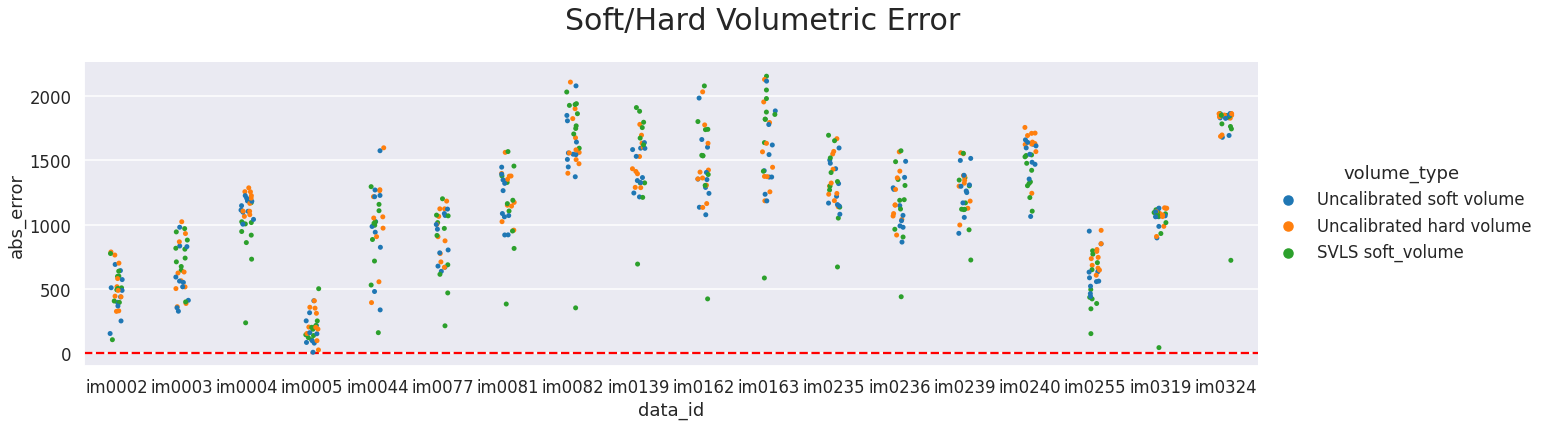

In [8]:
g = sns.catplot(
    melted_error_df,
    x="data_id",
    y="abs_error",
    hue="volume_type",
    aspect=3,
    height=6,
    sharex=False,
    sharey=False
)
# For each subplot make a line at y = 0 to show the error.
for ax in g.axes.flat:
    ax.axhline(0, ls='--', color='red')

# Adjust the layout
plt.subplots_adjust(top=0.85)
g.fig.suptitle('Soft/Hard Volumetric Error', fontsize=30)

# Show the plot
plt.show()

In [9]:
# We want to calculate now the average (across seeds) of the the absolute error for each method.
# That means first averaging within each seed, then averaging across seeds.
# We group by the data_id and the volume_type.
grouped = melted_error_df.groupby(["pretrained_seed", "volume_type"]).agg(
    abs_error=("abs_error", "mean"),
).reset_index()

In [10]:
# make a table with each row being the volume type, and the column being the abs_error mean with standard deviation in another column.
table = grouped.pivot_table(
    values="abs_error",
    index="volume_type",
    columns="pretrained_seed",
    aggfunc="mean",
)
# Average across the pretrained seeds to make an average column, and then make a stdv column.
table['mean'] = table.mean(axis=1)
table['stdv'] = table.std(axis=1)
# We can drop all other columns that aren't mean and stdv
table = table[['mean', 'stdv']]

In [11]:
table

pretrained_seed,mean,stdv
volume_type,,
SVLS soft_volume,1101.714153,216.302222
Uncalibrated hard volume,1174.257494,131.806204
Uncalibrated soft volume,1120.152770,125.846225
